<a href="https://colab.research.google.com/github/laxxitaasingh/Generative-Adversarial-Networks/blob/main/GANS_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [ ]:

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

     

In [ ]:

print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)

x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [ ]:

# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [ ]:

print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)


x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


In [ ]:

# Dimensionality of the latent space
latent_dim = 100

In [ ]:
# Defining the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model
     

In [ ]:
# Defining the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  
  model = Model(i, x)
  return model

In [ ]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

In [ ]:

generator.summary()
     

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1024)              5253

In [ ]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

z.shape

TensorShape([None, 100])

In [ ]:

# Pass noise through generator to get an image
img = generator(z)

In [ ]:
img

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_1')>

In [ ]:
# Make sure only the generator is trained
discriminator.trainable = False

In [ ]:
# The true output is fake, but we label them real!
# Passing the output of Generator to the Discriminator

fake_pred = discriminator(img)

In [ ]:

# Create the combined model object
combined_model_gen = Model(z, fake_pred)

In [ ]:

# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
     


In [ ]:
# Config

batch_size = 32
epochs = 3000
sample_period = 200 # every `sample_period` steps generate and save some data"
     

In [ ]:

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
# A function to generate a grid of random samples from the generator and save them to a file

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()
     

In [ ]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
    
    
    
   #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/3000, d_loss: 0.67,       d_acc: 0.61, g_loss: 0.73
epoch: 101/3000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.71
epoch: 201/3000, d_loss: 0.66,       d_acc: 0.53, g_loss: 0.76
epoch: 301/3000, d_loss: 0.63,       d_acc: 0.77, g_loss: 0.78
epoch: 401/3000, d_loss: 0.64,       d_acc: 0.69, g_loss: 0.78
epoch: 501/3000, d_loss: 0.61,       d_acc: 0.66, g_loss: 0.78
epoch: 601/3000, d_loss: 0.59,       d_acc: 0.66, g_loss: 0.90
epoch: 701/3000, d_loss: 0.63,       d_acc: 0.66, g_loss: 0.80
epoch: 801/3000, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.81
epoch: 901/3000, d_loss: 0.66,       d_acc: 0.58, g_loss: 0.88
epoch: 1001/3000, d_loss: 0.61,       d_acc: 0.67, g_loss: 0.86
epoch: 1101/3000, d_loss: 0.64,       d_acc: 0.67, g_loss: 0.92
epoch: 1201/3000, d_loss: 0.61,       d_acc: 0.69, g_loss: 0.92
epoch: 1301/3000, d_loss: 0.62,       d_acc: 0.62, g_loss: 0.95
epoch: 1401/3000, d_loss: 0.65,       d_acc: 0.66, g_loss: 0.84
epoch: 1501/3000, d_loss: 0.66,       d_acc: 0.66, g

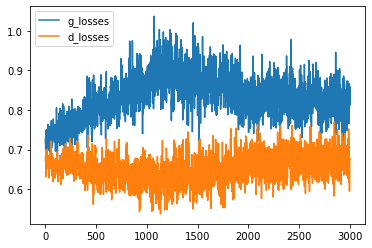

In [ ]:

plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

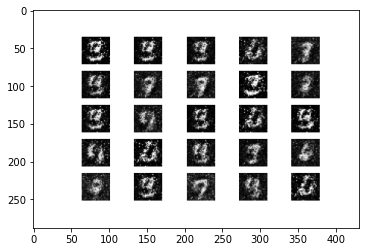

In [ ]:

from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

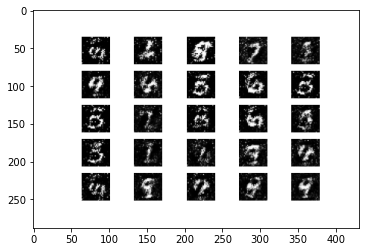

In [ ]:

a = imread('gan_images/1000.png')
plt.imshow(a)
     

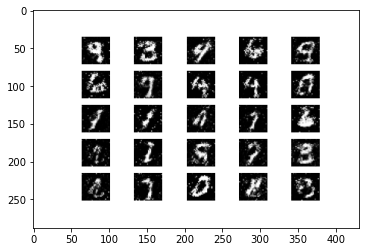

In [ ]:
a = imread('gan_images/2000.png')
plt.imshow(a)
     